In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 1
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c2_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c2_img20250512-11_57_42CEST.jpg"


delta_pitch_deg=15.0
delta_yaw_deg=0.0 
delta_roll_deg=0.0 
delta_r=0.0

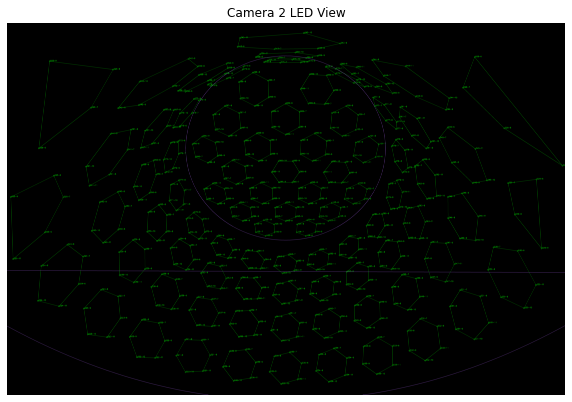

Saved image to camera2_f3253_p15_y0_r0_dr0.png


In [3]:
excluded_pmts = { 25, 26, 28, 29, 30, 32, 35, 45, 57, 59, 60, 61, 74, 75, 76, 77, 79, 85, 91, 96, 99, 102}

prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 50)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 230
number of blobs: 230


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c2_with_blob_annotation.jpg


In [6]:
# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = {
    '040-9': (1474, 3075),
    '064-11': (6723, 4031),
    '089-8': (4708, 1377),
    '105-9': (4523, 3624)
}

matches, fitpars = prim.match_blobs(
                            blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, 
                            excluded_pmts=excluded_pmts,
                            bounds = [
                                        (10, 20),   # delta_pitch_deg
                                        (-5, 5),   # delta_yaw_deg
                                        (-5, 5),   # delta_roll_deg
                                        (-0.01, 0.01), # delta_r in meters
                                        (-0.082, 0.086), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
                                        (-0.007, 0.009), # k2
                                        (-0.0005, 0.0008), # k3
                                        (-0.0001, 0.0002)   ],
                            control_points=control_points,  
                            use_lm=True )
                         

In [7]:
fitpars

{'delta_pitch_deg': 15.730375263640765,
 'delta_yaw_deg': 0.5680001692325598,
 'delta_roll_deg': 0.16929001653923936,
 'delta_r': 0.07758070914374532,
 'D_fit': array([ 0.11075632, -0.16167188,  0.16363184, -0.0506917 ]),
 'chi2': 7760511.191344148,
 'success': True}

In [8]:
len(matches)

224

In [9]:
matches

[('021-6', 3412.631, 5730.1177),
 ('021-7', 3263.968, 5475.0854),
 ('021-8', 2979.8193, 5463.818),
 ('021-9', 2831.43, 5728.169),
 ('021-10', 2994.8628, 6004.5825),
 ('022-6', 2633.3718, 5475.07),
 ('022-7', 2519.319, 5169.718),
 ('022-8', 2229.7903, 5113.8335),
 ('022-9', 2032.3838, 5397.835),
 ('022-10', 2163.8953, 5738.038),
 ('022-11', 2473.6013, 5757.205),
 ('023-7', 1823.9752, 4705.356),
 ('023-8', 1529.1676, 4589.7524),
 ('023-9', 1245.6301, 4904.43),
 ('023-10', 1323.0105, 5338.755),
 ('023-11', 1651.8944, 5399.231),
 ('024-6', 1174.4021, 4500.922),
 ('024-7', 1221.1505, 4013.0347),
 ('024-8', 930.1606, 3804.221),
 ('024-9', 498.759, 4160.506),
 ('024-10', 468.98917, 4748.912),
 ('031-6', 8079.817, 4703.103),
 ('031-7', 7737.2944, 4604.316),
 ('031-8', 7544.841, 4890.842),
 ('031-9', 7641.4883, 5284.819),
 ('031-11', 8211.655, 5153.031),
 ('033-6', 6557.8276, 5572.0845),
 ('033-7', 6305.315, 5433.0767),
 ('033-8', 6061.449, 5587.462),
 ('033-9', 6044.144, 5883.4497),
 ('033-10'

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,    
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 15.730375263640765, 'delta_yaw_deg': 0.5680001692325598, 'delta_roll_deg': 0.16929001653923936, 'delta_r': 0.07758070914374532, 'D_fit': array([ 0.11075632, -0.16167188,  0.16363184, -0.0506917 ]), 'chi2': 7760511.191344148, 'success': True}
Overlay image saved to: c2_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {74, 75, 76, 77, 79, 85, 25, 26, 91, 28, 29, 30, 32, 96, 35, 99, 102, 45, 57, 59, 60, 61}
geo_file= wcte_geometry_file.json
Sample matches labels: [('021-6', 3412.631, 5730.1177), ('021-7', 3263.968, 5475.0854), ('021-8', 2979.8193, 5463.818), ('021-9', 2831.43, 5728.169), ('021-10', 2994.8628, 6004.5825), ('022-6', 2633.3718, 5475.07), ('022-7', 2519.319, 5169.718), ('022-8', 2229.7903, 5113.8335), ('022-9', 2032.3838, 5397.835), ('022-10', 2163.8953, 5738.038)]
Sample label_to_sim keys: ['021-6', '021-7', '021-8', '021-9', '021-10', '021-11', '022-6', '022-7', '022-8', '022-9']
Saved results to c2_img20250512-12_06_55CEST.json
